# RandomForest
We want to create a model using Random Forest

Fitting 2 folds for each of 720 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  3.0min finished
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


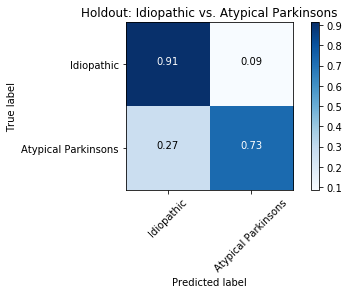

Fitting 2 folds for each of 720 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  2.6min finished


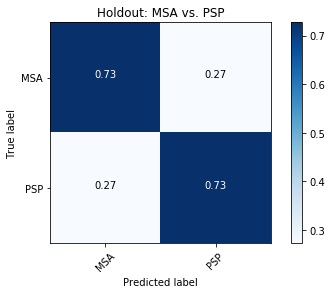

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, make_scorer, confusion_matrix

import ml_utils as mu

# groups to model
groupings = [
#     {'name': 'cvp', 'grouping':{0:0, 1:1, 2:1, 3:1}, 'description':'Control vs. All Parkinsons'},
    {'name': 'iva', 'grouping':{1:0, 2:1, 3:1},'description':'Idiopathic vs. Atypical Parkinsons'},
    {'name': 'mvp', 'grouping':{2:0, 3:1},'description':'MSA vs. PSP'},
#     {'name': 'ipvm', 'grouping':{1:0, 2:1, 3:0},'description':'Idiopathic and PSP vs. MSA'},
#     {'name': 'imvp', 'grouping':{1:0, 2:0, 3:1},'description':'Idiopathic and MSA vs. PSP'},
]

# parameters to optimize on
params = {
            "classifier__n_estimators": [500],
            #     "classifier__max_features": range(1, 38, 2),
            #     "classifier__max_depth": range(1, 21, 2),
            "classifier__min_samples_split": range(2, 20, 2),
            "classifier__min_samples_leaf": range(1, 25, 3),
            "kbest__k": range(1, 11),
        }

# read in the data
data = pd.read_excel('data/Training_with_Patterns.xlsx').drop(['Subject'], axis=1)

# for each grouping, split into test and holdout sets and train the model
for grouping in groupings:
    name = grouping['name']
    description = grouping['description']
    
    grouped_data = mu.group_classes(data, grouping['grouping'])
        
    y = grouped_data['GroupID']
    X = grouped_data.drop(['GroupID'], axis=1)
    
    X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size = 0.2, stratify=y)

    pipeline = Pipeline([
        ("standardization", StandardScaler()),
        ('oversampler', RandomOverSampler()),
        ('kbest', SelectKBest(score_func=f_classif, k=7)),
        ("classifier", RandomForestClassifier())
    ])
    
    clf = GridSearchCV(estimator=pipeline, param_grid=params, scoring=make_scorer(matthews_corrcoef), cv=2, n_jobs=-1, verbose=2)
    clf.fit(X_train, y_train)
    best_clf = clf.best_estimator_
    
    yh_pred = best_clf.predict(X_holdout)
    get_confusion_matrix(y_holdout, yh_pred, classes=description.split(' vs. '), title='Holdout: %s' %description)

In [1]:
import matplotlib.pyplot as plt
import itertools

def get_confusion_matrix(y, y_pred, classes, title="Confusion Matrix"):
    cnf_matrix = confusion_matrix(y, y_pred)
    plot_confusion_matrix(cnf_matrix, normalize=True, classes=classes, title=title)
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Stats to track:

* Model Name
* CV
* Datetime
* best parameters
* variant code
* description
* data file name
* validation data file name
* time_elapsed
*

For each cross_validation, holdout, validation:
* Sensitivity (Recall, True Positive Rate)
* Specificity (True Negative Rate)
* Precision  (Positive Predictive Value (PPV))
* Negative Predictive Value (NPV)
* Accuracy
* AUC
* MCC 

and standard deviation for each

### TODO:
* Setup db to track above stats on every run
* Run the full suite again @ 2,5,10,20 fold

Hopefully a model for each grouping where precision and recall > 0.75 (ideally > 0.80 )

### Variants to Try
* Don't run control vs. parkinsonism to save time
* Additional groupings for MSA vs. Idiopathic and PSP, PSP vs. Idiopathic and MSA
* PCA
* Feature Subset Selection
* Removing outliers
* Normalizing the input data
* Correcting for skewdness
* For MSA vs. PSP: MCP_FW (FA), SCP_FW, PUTAMEN_FW (FA), LOBULE_VI_FW,  LOBULE_V_FW
* ???? MCP/SCP ratio?